Завдання полягає в тому, щоб класифікувати, чи мають дві надані пари питань однакове значення.\
Рішення буде оцінюватися за допомогою метрики Cross-Entropy Loss між передбаченими значеннями й реальними мітками. Чим нижчий результат метрики Cross-Entropy Loss, тим краща модель. 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Функції

In [3]:
# Діаграми щільності розподілу для піднабору 1 і піднабору 0 
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'duplicate')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'non_duplicate')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

# Попередній аналіз даних

In [4]:
df_train = pd.read_csv('./data/quora_question_pairs_train.csv.zip', index_col = 0)

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
# Загальний вигляд даних
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1


In [7]:
# Розмір набору
df_train.shape

(323432, 5)

In [8]:
# Перевірка типів даних, наявності пропущених значень
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


Є лише три пропущених значення: одне у полі `question 1` і два у полі `question 2`.\
Це зовсім несуттєва кількість на наборі такого розміру, тому рядки з пропущеними значеннями можна просто видалити (більше того, їх треба видалити, бо якщо немає запису у полі `question 1` чи полі `question 2`, то просто немає чого з чим порівнювати).

In [9]:
df_train.dropna(subset = ['question1', 'question2'], inplace=True)

In [10]:
# Перевірка кількості ненулевих значень у стовпцях після видалення пропущених значень
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323429 non-null  int64 
 1   qid2          323429 non-null  int64 
 2   question1     323429 non-null  object
 3   question2     323429 non-null  object
 4   is_duplicate  323429 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


In [11]:
# Перевірка дисбалансу класів для цільового стовпця (в абсолютних значеннях)
df_train['is_duplicate'].value_counts().sort_values(ascending = False)

is_duplicate
0    204019
1    119410
Name: count, dtype: int64

In [12]:
# Перевірка дисбалансу класів для цільового стовпця (у відносних значеннях)
df_train['is_duplicate'].value_counts(normalize = True).sort_values(ascending = False) * 100

is_duplicate
0    63.079996
1    36.920004
Name: proportion, dtype: float64

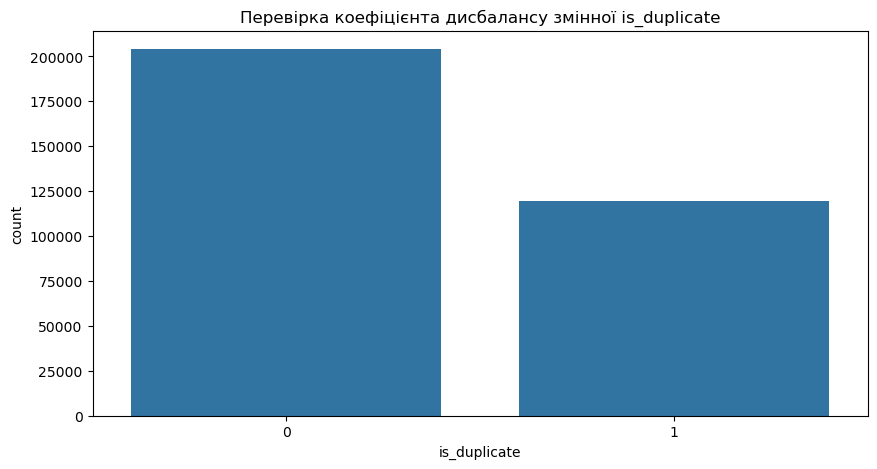

In [13]:
# Візуалізація розподілу класів
plt.figure(figsize = (10,5))
sns.countplot(x = df_train['is_duplicate'], data = df_train)
plt.title('Перевірка коефіцієнта дисбалансу змінної is_duplicate')
plt.show()

Дисбаланс класів присутній, але він не надто сильний.

In [14]:
# Додавання стовпців з довжинами текстів question1 і question2 в символах
df_train['question1_length'] = df_train.question1.apply(lambda x: len(x))
df_train['question2_length'] = df_train.question2.apply(lambda x: len(x))
df_train.head()

,qid1,qid2,question1,question2,is_duplicate,question1_length,question2_length
id,,,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0,47,81
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0,62,55
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0,32,78
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0,51,42
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1,159,68


In [15]:
df_train['question1_length'].nunique()

323

In [16]:
df_train['question1_length'].value_counts()

question1_length
45     6835
44     6828
42     6749
43     6652
47     6597
       ... 
370       1
339       1
340       1
430       1
311       1
Name: count, Length: 323, dtype: int64

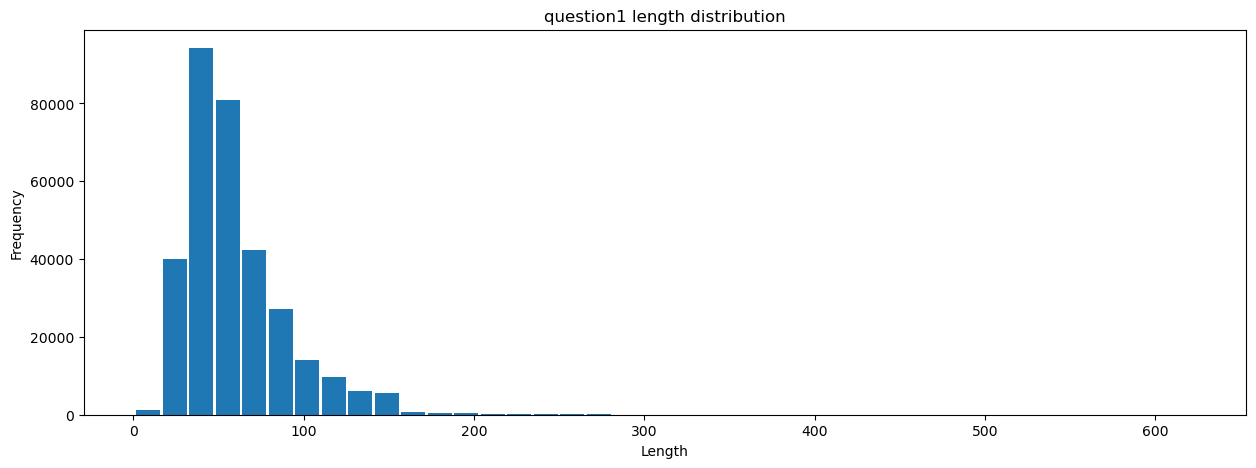

In [17]:
# Візуалізація розподілу довжин текстів question1
plt.figure(figsize = (15, 5))
plt.hist(df_train['question1_length'], bins = 40, rwidth = 0.9)
plt.title('question1 length distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show();

- У тексті `question1` зустрічаються тексти 323-ти різних довжин.
- Найбільше текстів `question1` довжиною у 45 символів. Таких є 6835 штук.
- Розподіл довжин текстів `question1` скошений вправо. Зі збільшенням довжини тексту кількість таких, довгих, текстів зменшується.

In [18]:
df_train['question2_length'].nunique()

369

In [19]:
df_train['question2_length'].value_counts()

question2_length
44     7662
43     7443
42     7045
40     6981
45     6864
       ... 
519       1
354       1
1         1
337       1
336       1
Name: count, Length: 369, dtype: int64

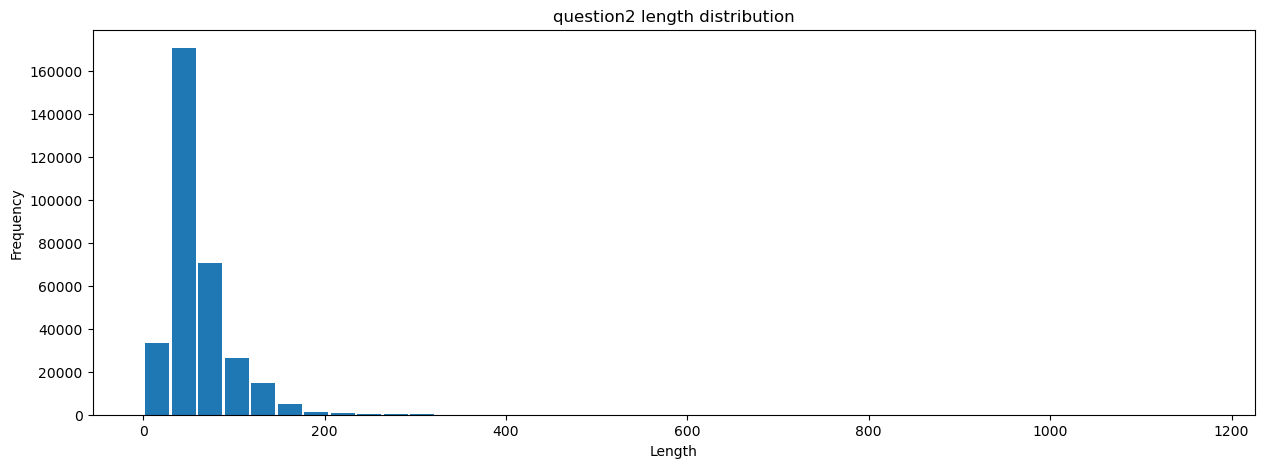

In [20]:
# Візуалізація розподілу довжин текстів question2
plt.figure(figsize = (15, 5))
plt.hist(df_train['question2_length'], bins = 40, rwidth = 0.9)
plt.title('question2 length distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show();

- У тексті `question2` зустрічаються тексти 369-ти різних довжин.
- Найбільше текстів `question2` довжиною у 44 символи. Таких є 7662 штук.
- Розподіл довжин текстів `question2` скошений вправо. Зі збільшенням довжини тексту кількість таких, довгих, текстів зменшується.

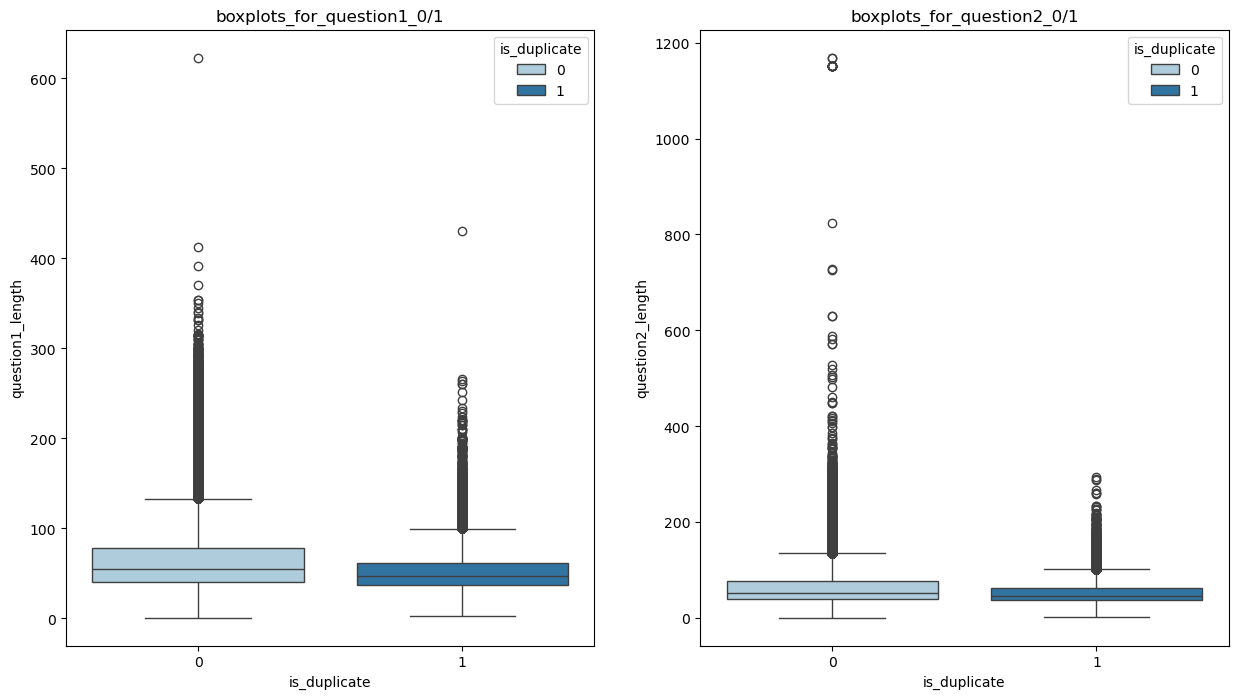

In [21]:
# Діаграми розмаху довжини текстів для question1 і question2 залежно від того є відмітка про дублікат чи ні 
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
sns.boxplot(data = df_train, x = "is_duplicate", y = "question1_length", hue = 'is_duplicate', palette = "Paired")
plt.title('boxplots_for_question1_0/1')

plt.subplot(1, 2, 2)
sns.boxplot(data = df_train, x = "is_duplicate", y = "question2_length", hue = 'is_duplicate', palette = "Paired")
plt.title('boxplots_for_question2_0/1')

plt.show()

In [22]:
# Розподіл даних тренувального набору на основі класів
df_train_non_duplicates = df_train[df_train['is_duplicate'] == 0]
df_train_duplicates = df_train[df_train['is_duplicate'] == 1] 

**Пошук викидів в `question1_length` для випадків відсутності відмітки про дублікат**

In [23]:
Q1 = df_train_non_duplicates['question1_length'].quantile(0.25)
Q3 = df_train_non_duplicates['question1_length'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

37.0


In [24]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -14.5
Максимальне значення, після якого існують викиди: 133.5


**Пошук викидів в `question1_length` для випадків наявності відмітки про дублікат**

In [25]:
Q1 = df_train_duplicates['question1_length'].quantile(0.25)
Q3 = df_train_duplicates['question1_length'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

25.0


In [26]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -0.5
Максимальне значення, після якого існують викиди: 99.5


**Видалення викидів і побудова діаграми щільності розподілу**

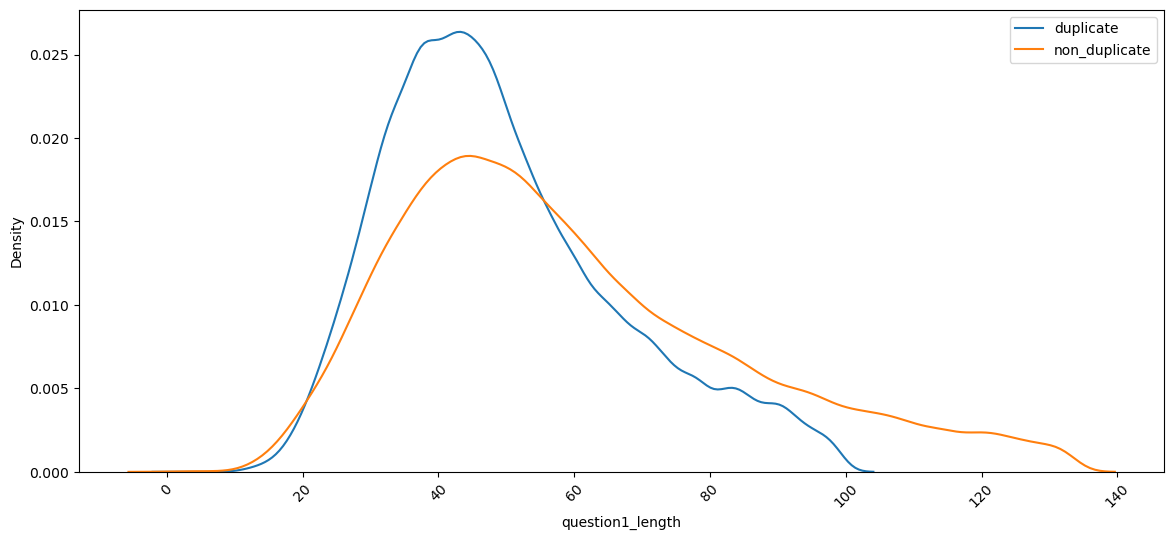

In [27]:
kde_no_outliers(df_train_non_duplicates, df_train_duplicates, Max_value0, Max_value1, 'question1_length')

- Для `question1`, які мають відмітку про дублікат, ймовірність потрапити у діапазон довжини тексту у 20-60 символів більша ймовірності потрапити у цей діапазон тим питанням `question1`, які цієї відмітки не мають.
- Натомість, для тих `question1`, які мають відмітку про дублікат, ймовірність потрапити у діапазон довжини тексту більше 60 символів менша ймовірності потрапити у цей діапазон тим `question1`, які цієї відмітки не мають.

**Пошук викидів в `question2_length` для випадків відсутності відмітки про дублікат**

In [28]:
Q1 = df_train_non_duplicates['question2_length'].quantile(0.25)
Q3 = df_train_non_duplicates['question2_length'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

38.0


In [29]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -17.0
Максимальне значення, після якого існують викиди: 135.0


**Пошук викидів в `question2_length` для випадків наявності відмітки про дублікат**

In [30]:
Q1 = df_train_duplicates['question2_length'].quantile(0.25)
Q3 = df_train_duplicates['question2_length'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

26.0


In [31]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -2.0
Максимальне значення, після якого існують викиди: 102.0


**Видалення викидів і побудова діаграми щільності розподілу**

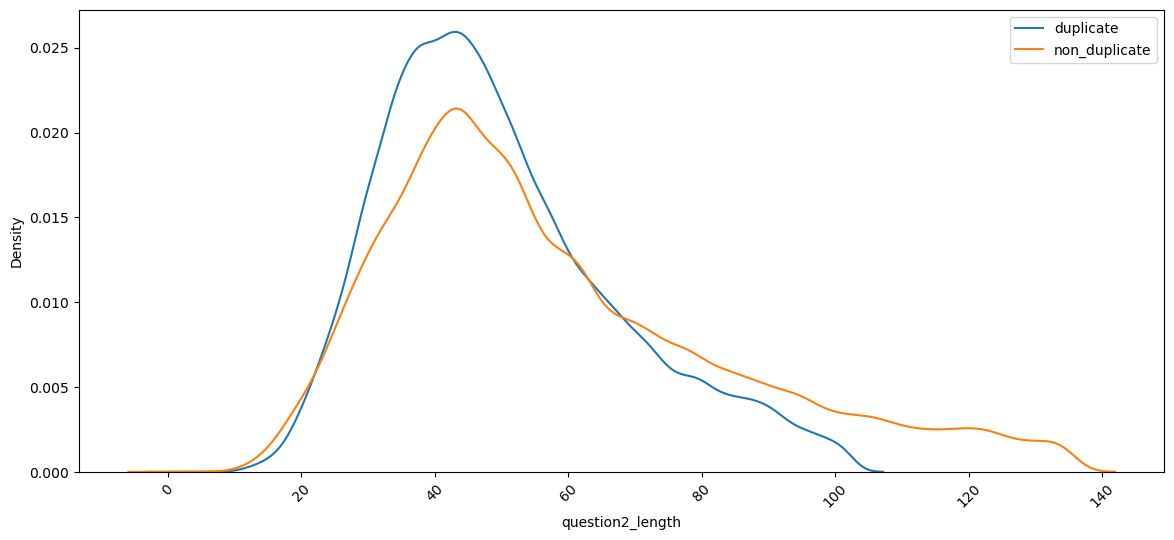

In [32]:
kde_no_outliers(df_train_non_duplicates, df_train_duplicates, Max_value0, Max_value1, 'question2_length')

Для діаграми щільності розподілу довжин текстів `question2` ситуація майже ідентична до картини з `question1`.\
Тексти, відмічені як дублікати, здебільшого мають коротшу довжину.

# Попередня обробка тексту

In [33]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

# Функція токенізації, видалення стоп-слів і стеммінгу
def tokenize_stopwords_stem(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in english_stopwords]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [34]:
df_train['question1_stemmed_tokenized'] = df_train['question1'].apply(tokenize_stopwords_stem)
df_train['question2_stemmed_tokenized'] = df_train['question2'].apply(tokenize_stopwords_stem)

In [35]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate,question1_length,question2_length,question1_stemmed_tokenized,question2_stemmed_tokenized
id,,,,,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0,47,81,"[iliad, odyssey, greek, cultur, ?]","[prove, pair, three, independ, variabl, also, independ, ?]"
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0,62,55,"[practic, manag, strateg, manag, ?]","[practic, aspect, strateg, manag, ?]"
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0,32,78,"[use, makeuseof, answer, ?]","[q, &, site, yahoo, answer, ,, hate, speech, allow, ?]"
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0,51,42,"[best, place, resid, india, ?]","[ia, best, place, visit, india, ?]"
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1,159,68,"[mani, peopl, ask, question, quora, easili, answer, number, legitim, sourc, web, ?, heard, googl, bing, ?]","[n't, mani, peopl, post, question, quora, check, googl, first, ?]"


In [36]:
df_train['common_words_count'] = df_train.apply(
                                    lambda row: len(set(row['question1_stemmed_tokenized']).intersection(row['question2_stemmed_tokenized'])), axis=1)


In [37]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate,question1_length,question2_length,question1_stemmed_tokenized,question2_stemmed_tokenized,common_words_count
id,,,,,,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0,47,81,"[iliad, odyssey, greek, cultur, ?]","[prove, pair, three, independ, variabl, also, independ, ?]",1
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0,62,55,"[practic, manag, strateg, manag, ?]","[practic, aspect, strateg, manag, ?]",4
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0,32,78,"[use, makeuseof, answer, ?]","[q, &, site, yahoo, answer, ,, hate, speech, allow, ?]",2
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0,51,42,"[best, place, resid, india, ?]","[ia, best, place, visit, india, ?]",4
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1,159,68,"[mani, peopl, ask, question, quora, easili, answer, number, legitim, sourc, web, ?, heard, googl, bing, ?]","[n't, mani, peopl, post, question, quora, check, googl, first, ?]",6


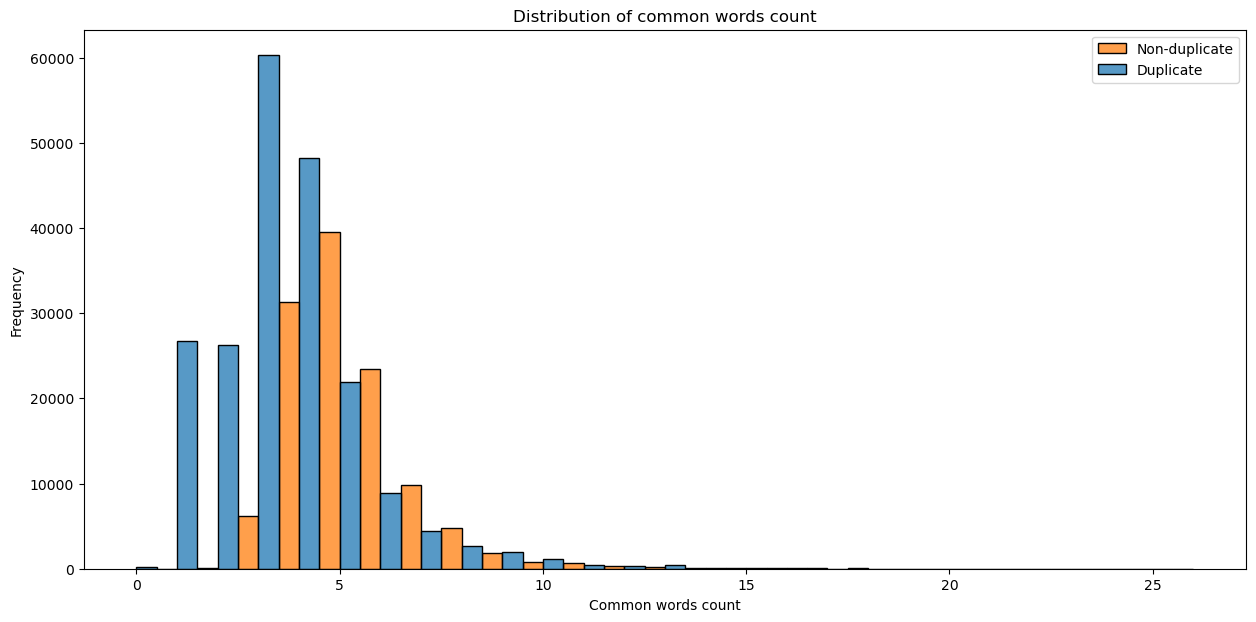

In [38]:
plt.figure(figsize = (15,7))
sns.histplot(data = df_train,
             x = 'common_words_count',
             hue = 'is_duplicate',
             bins = range(df_train['common_words_count'].max()),
             multiple = 'dodge')
plt.xlabel('Common words count')
plt.ylabel('Frequency')
plt.title('Distribution of common words count')
plt.legend(labels = ['Non-duplicate', 'Duplicate'])
plt.show()

Схоже, якщо спільних слів менше 5, то питання більш ймовірно є дублікатами. Якщо спільних слів більше 5, то питання більш ймовірно не є дублікатами.
І, схоже, BoW не є хорошим методом для цієї задачі. Варто спробувати TF-IDF.

In [39]:
df_train['question1_stemmed_tokenized_str'] = df_train['question1_stemmed_tokenized'].apply(lambda x: ' '.join(x))
df_train['question2_stemmed_tokenized_str'] = df_train['question2_stemmed_tokenized'].apply(lambda x: ' '.join(x))

In [40]:
df_train['combined_words'] = df_train['question1_stemmed_tokenized_str'] + ' ' + df_train['question2_stemmed_tokenized_str']

In [41]:
tf_idf_vectorizer = TfidfVectorizer(lowercase = True,
                                   tokenizer = tokenize_stopwords_stem)
tf_idf_vectorizer.fit(df_train['combined_words'])
inputs = tf_idf_vectorizer.transform(df_train['combined_words'])
inputs.shape

C:\Users\Admin\anaconda3\envs\py3921\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(323429, 79498)

# Моделювання

In [42]:
X_train, X_test, y_train, y_test = train_test_split(inputs, df_train['is_duplicate'], test_size = 0.25, random_state = 42)

**LogisticRegression**

In [51]:
log_reg = LogisticRegression(solver = 'sag', max_iter = 1000, random_state = 42)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)

log_loss_val = log_loss(y_train, y_train_proba[:, 1])
roc_auc_val = roc_auc_score(y_train, y_train_pred)
print('Log loss value = {},\nRoc_auc_score value = {}'.format(log_loss_val, roc_auc_val))

Log loss value = 0.47979819495451126,
Roc_auc_score value = 0.7291424500110018


In [55]:
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)

log_loss_val = log_loss(y_test, y_test_proba[:, 1])
roc_auc_val = roc_auc_score(y_test, y_test_pred)
print('Log loss value = {},\nRoc_auc_score value = {}'.format(log_loss_val, roc_auc_val))

Log loss value = 0.5108376605957761,
Roc_auc_score value = 0.706469162719178


Результати логістичної регресії не зовсім задовільні.

Очевидно, що задача потребує продовження досліджень і подальших експериментів.